<a href="https://colab.research.google.com/github/abhishek-1406/SafeScanTool/blob/main/Models/FINAL_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The script is intended to train the SVM(Support Vector Machines) model to detect whether the text given is hateful or not.

It is used to install the scikit-learn libraries into the environment for the purpose of machine learning utilities.

In [ ]:
!pip install pandas scikit-learn
!pip install shap
import shap

Here, we have imported the pandas libraries for the purpose of data manipulation.

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

The dataset file has been read and top 10 rows is being displayed using head().

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required nltk resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load the updated dataset
hate_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/updated_hatexplain_data.csv')

label_mapping = {'normal': 0, 'offensive': 1, 'hatespeech': 2}
hate_data['label'] = hate_data['majority_label'].map(label_mapping)
print("Label Distribution:\n", hate_data['label'].value_counts())

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
custom_stopwords = ['user', 'number', 'people', 'get', 'like', 'go', 'know', 'think', 'time']
stop_words.update(custom_stopwords)
lemmatizer = WordNetLemmatizer()

# Define the clean_text function
def clean_text(text):
    """
    Preprocesses the input text by:
    - Lowercasing
    - Removing URLs, @mentions, and special characters
    - Lemmatization
    - Removing stopwords (common and custom)
    """
    if not isinstance(text, str):
        return ''

    # Lowercase the text
    text = text.lower()

    # Remove URLs and @mentions
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)

    # Remove non-alphabetic characters and extra spaces
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize, remove stopwords, and lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]

    return ' '.join(words)

# Apply the function to the 'post_text' column
hate_data['cleaned_text'] = hate_data['cleaned_text'].apply(clean_text)

# To calculate the length of each post_text (number of characters)
hate_data['text_length'] = hate_data['cleaned_text'].apply(len)

# Check first few rows of the cleaned text
hate_data[['cleaned_text', 'label']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Label Distribution:
 label
1    24670
0    12896
2     7365
Name: count, dtype: int64


,cleaned_text,label
0,dont im getting baby white two white j nike ev...,0
1,cannot continue calling feminist right womxn a...,0
2,nawt yall nigger ignoring,0
3,bit confused coz chinese ppl access twitter th...,2
4,bitch whataburger eating burger top bun holdin...,2


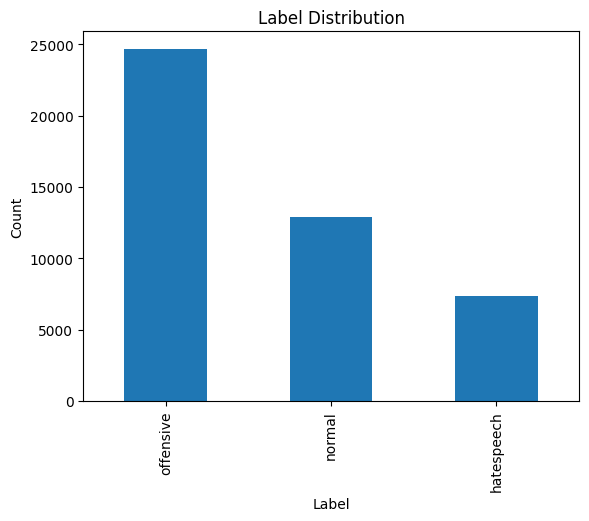

In [ ]:
import matplotlib.pyplot as plt

hate_data['majority_label'].value_counts().plot(kind='bar')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


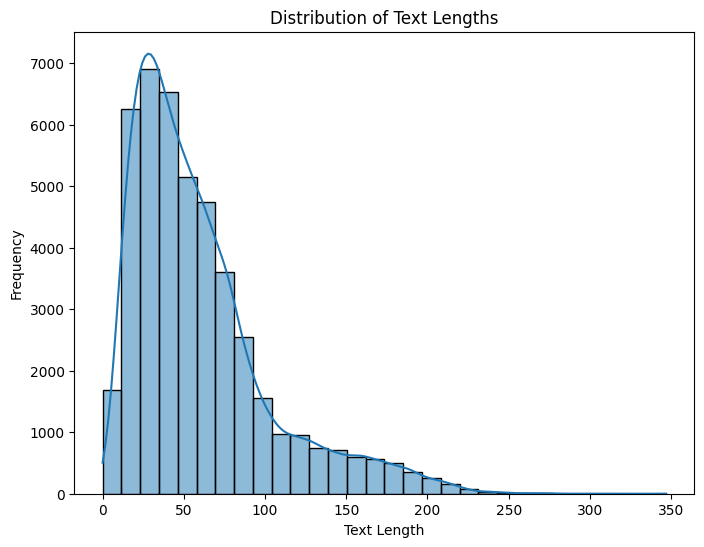

In [ ]:
import seaborn as sns
# Text length distribution plot
hate_data['text_length'] = hate_data['cleaned_text'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

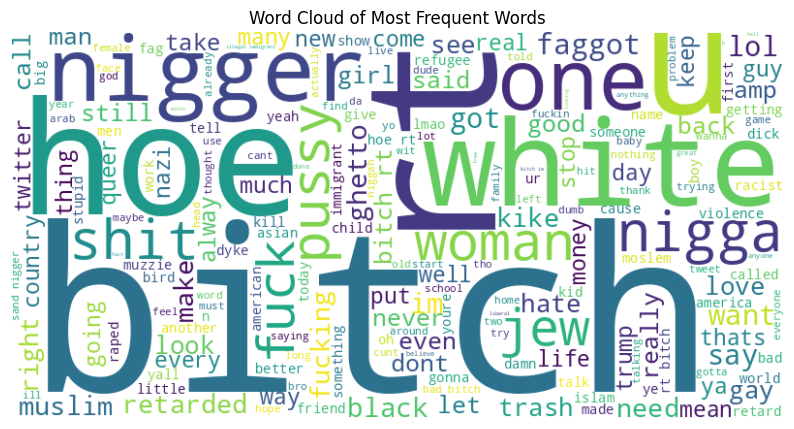

In [ ]:
from wordcloud import WordCloud

text = " ".join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()


It onverts cleaned text into TF-IDF feature vectors(x) and extracts its corresponding labels(y) in order to prepare this data for training a SVM machine learning model.

In [ ]:
# TF-IDF Vectorization Operation

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=30000)
X = vectorizer.fit_transform(hate_data['cleaned_text'])
y = hate_data['label']

It is used to split the dataset into 80% training and 20% testing keeping same class distribution using stratified sampling technique

In [ ]:
# Train/Test Split of Dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

It creates a linear support vector classifier qith balanced class weights that trains on TF-IDF features and labels.

In [ ]:
# Class imbalance handling
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("Class Weights:", class_weight_dict)


Class Weights: {0: np.float64(1.1613195050240703), 1: np.float64(0.6071108859049067), 2: np.float64(2.033491740212718)}


In [ ]:
# SVM Classifier
svm_model = LinearSVC(class_weight=class_weight_dict, max_iter=100000)
svm_model.fit(X_train, y_train)

LinearSVC(class_weight={0: np.float64(1.1613195050240703),
                        1: np.float64(0.6071108859049067),
                        2: np.float64(2.033491740212718)},
          max_iter=100000)

It provides a classification report for each class mentioned in dataset and prints a confusion matrix reporting correct and incorrect predictions.

In [ ]:
# Prediction and Evaluation
y_pred = svm_model.predict(X_test)

print("\nClassification Report:\n", classification_report(
    y_test, y_pred, target_names=["Normal", "Offensive", "HateSpeech"]))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

      Normal       0.67      0.73      0.70      2579
   Offensive       0.84      0.79      0.82      4935
  HateSpeech       0.63      0.63      0.63      1473

    accuracy                           0.75      8987
   macro avg       0.71      0.72      0.71      8987
weighted avg       0.76      0.75      0.75      8987


Confusion Matrix:
 [[1889  450  240]
 [ 703 3913  319]
 [ 247  292  934]]


In [ ]:
import joblib

# Save
joblib.dump(svm_model, "svm_hatespeech_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [ ]:
# Load later
clf_loaded = joblib.load("svm_hatespeech_model.pkl")
vectorizer_loaded = joblib.load("tfidf_vectorizer.pkl")

In [ ]:
# Recreate X_train using the loaded vectorizer (important for SHAP)
print(f"Cleaned Text: {hate_data['cleaned_text']}")
X_train_loaded = vectorizer_loaded.transform(df['cleaned_text'])
print(f"Vectorized Input Shape: {X_train_loaded.shape}")

Cleaned Text: 0        dont im getting baby white two white j nike ev...
1        cannot continue calling feminist right womxn a...
2                                nawt yall nigger ignoring
3        bit confused coz chinese ppl access twitter th...
4        bitch whataburger eating burger top bun holdin...
                               ...                        
44926    yous muthafin lie right tl trash mine bible sc...
44927    youve gone broke wrong heart baby drove rednec...
44928      young buck wanna eat dat nigguh aint fuckin dis
44929                       youu got wild bitch tellin lie
44930    ruffled ntac eileen dahlia beautiful color com...
Name: cleaned_text, Length: 44931, dtype: object
Vectorized Input Shape: (44931, 30000)


In [ ]:
import re

def predict_hate(text):
    # Clean text like training
    text_cleaned = text.lower()
    text_cleaned = re.sub(r"<.*?>", "", text_cleaned)

    X_input = vectorizer_loaded.transform([text_cleaned])

    pred = clf_loaded.predict(X_input)[0]

    label_reverse = {0: "Normal", 1: "Offensive", 2: "HateSpeech"}
    label = label_reverse[pred]

    print(f"Text: {text}\nPrediction: {label}")

    # SHAP Explanation (Bar Plot)
    shap_values_svm = explainer_svm(X_input)
    shap.plots.bar(shap_values_svm, max_display=10)

    # Top Contributing Words
    feature_importances = shap_values_svm.values[0]
    feature_names = vectorizer_loaded.get_feature_names_out()
    important_indices = np.argsort(feature_importances)[-10:][::-1]

    print("\nTop contributing words:")
    for idx in important_indices:
        if idx < len(feature_names):
            print(f"{feature_names[idx]}: {feature_importances[idx]:.4f}")

Retraining the model with different hyperparameters

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack

# 1. DOWNLOAD NLTK RESOURCES

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# 2. TEXT CLEANING FUNCTION

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)               # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)           # Remove special chars/numbers
    text = " ".join([lemmatizer.lemmatize(word)
                     for word in text.split()
                     if word not in stop_words and len(word) > 1])
    return text


# 3. LOAD YOUR DATASET

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/updated_hatexplain_data.csv")

# Clean the text
df['cleaned_text'] = df['cleaned_text'].apply(clean_text)

# Preserve your original labels
label_mapping = {'normal': 0, 'offensive': 1, 'hatespeech': 2}
df['label'] = df['majority_label'].map(label_mapping)

# 4. SPLIT DATA

X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. TF-IDF VECTORIZERS (WORD + CHAR)

word_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1,3),
    max_features=30000
)

char_vectorizer = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3,5),
    max_features=30000
)

# Fit & transform the training data
word_train = word_vectorizer.fit_transform(X_train)
char_train = char_vectorizer.fit_transform(X_train)

# Transform the test data
word_test = word_vectorizer.transform(X_test)
char_test = char_vectorizer.transform(X_test)

# Combine word and character features
X_train_combined = hstack([word_train, char_train])
X_test_combined = hstack([word_test, char_test])


# 6. HANDLE CLASS IMBALANCE (SMOTE)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)


# 7. HYPERPARAMETER TUNING (GridSearchCV)

param_grid = {
    'C': [0.1, 1, 5, 10],
    'max_iter': [5000, 10000, 20000]
}

grid = GridSearchCV(
    estimator=LinearSVC(class_weight='balanced'),
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train_resampled, y_train_resampled)

best_model = grid.best_estimator_
print(f"\nBest Hyperparameters: {grid.best_params_}\n")

# 8. EVALUATION
y_pred = best_model.predict(X_test_combined)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["normal", "offensive", "hatespeech"]))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred, labels=[0,1,2]))


print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

In [ ]:
import os

# Ensure the directory exists
save_dir = "/content/drive/MyDrive/models"
os.makedirs(save_dir, exist_ok=True)

# Now save the model & vectorizers
joblib.dump(best_model, f"{save_dir}/svm_hater_speech_model.pkl")
joblib.dump(word_vectorizer, f"{save_dir}/words_vectorizer.pkl")
joblib.dump(char_vectorizer, f"{save_dir}/chars_vectorizer.pkl")

print("\nModel and vectorizers saved successfully!")

In [ ]:
# 10. PREDICT FUNCTION FOR NEW TEXTS
def predict_text(new_text):
    # Load model & vectorizers (if not already in memory)
    model = joblib.load("/content/drive/MyDrive/models/svm_hater_speech_model.pkl")
    word_vec = joblib.load("/content/drive/MyDrive/models/words_vectorizer.pkl")
    char_vec = joblib.load("/content/drive/MyDrive/models/chars_vectorizer.pkl")

    # Clean and vectorize the new text
    cleaned = clean_text(new_text)
    word_features = word_vec.transform([cleaned])
    char_features = char_vec.transform([cleaned])
    combined_features = hstack([word_features, char_features])

    # Predict the label
    prediction = model.predict(combined_features)[0]
    return prediction

# ================================
# 11. TESTING THE PREDICT FUNCTION
# ================================
test_sentences = [
    "I hate you, go back to your country!",    # Hate speech
    "You are stupid but whatever",            # Offensive
    "Blacks are slaves."     # Normal
]

for text in test_sentences:
    print(f"Text: {text} --> Prediction: {predict_text(text)}")


SHAP LOGIC

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Text: I hate you, go back to your country! --> Prediction: 1

🔍 EXPLAINING: I hate you, go back to your country!


  0%|          | 0/1 [00:00<?, ?it/s]


Top contributing words:
hate: -0.285
go: +0.237
go back: -0.193
back: +0.157
country: -0.155


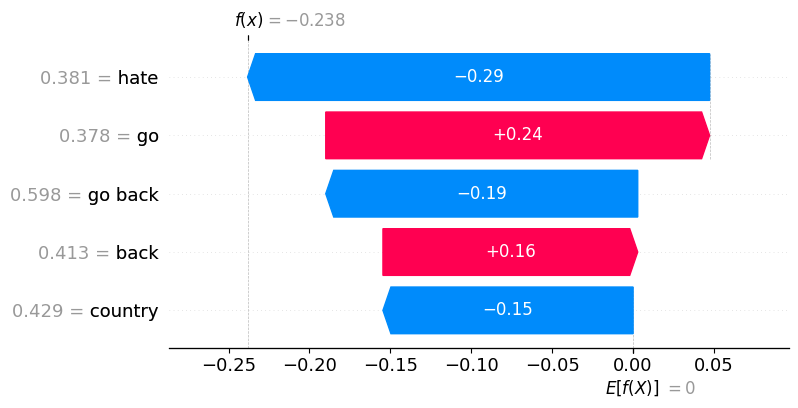

Text: You are stupid but whatever --> Prediction: 1

🔍 EXPLAINING: You are stupid but whatever


  0%|          | 0/1 [00:00<?, ?it/s]


Top contributing words:
stupid: +0.433
whatever: +0.337


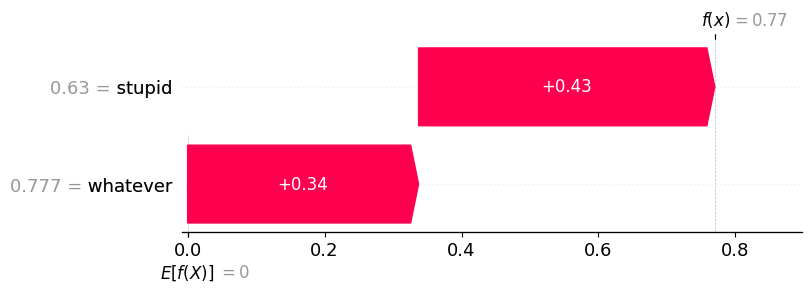

Text: Blacks are slaves. --> Prediction: 0

🔍 EXPLAINING: Blacks are slaves.


  0%|          | 0/1 [00:00<?, ?it/s]

⚠ No word-level features found for this text (likely unseen words).


In [ ]:
import shap
import joblib
import numpy as np
from scipy.sparse import hstack

# Load model & vectorizers
model = joblib.load("/content/drive/MyDrive/models/svm_hater_speech_model.pkl")
word_vec = joblib.load("/content/drive/MyDrive/models/words_vectorizer.pkl")
char_vec = joblib.load("/content/drive/MyDrive/models/chars_vectorizer.pkl")

# Clean text function
def clean_text(text):
    return text.lower()

# Combine features for text
def vectorize_text(texts):
    cleaned = [clean_text(t) for t in texts]
    word_features = word_vec.transform(cleaned)
    char_features = char_vec.transform(cleaned)
    return hstack([word_features, char_features])

# Predict function
def predict_text(new_text):
    features = vectorize_text([new_text])
    prediction = model.predict(features)[0]
    return prediction

import shap
import numpy as np

def explain_text(new_text):
    print(f"\n🔍 EXPLAINING: {new_text}")

    # Full vector (word + char) for model
    full_features = vectorize_text([new_text])
    dense_full_features = full_features.toarray()

    # Baseline for KernelExplainer
    background = np.zeros((1, dense_full_features.shape[1]))
    explainer = shap.KernelExplainer(model.predict, background)
    shap_values = explainer.shap_values(dense_full_features)

    # Handle multi-class
    predicted_class = model.predict(full_features)[0]
    if isinstance(shap_values, list):
        shap_values_class = np.array(shap_values[predicted_class][0]).flatten()
        base_value = explainer.expected_value[predicted_class]
    else:
        shap_values_class = np.array(shap_values[0]).flatten()
        base_value = explainer.expected_value

    # Focus only on word-level features
    word_feature_count = len(word_vec.get_feature_names_out())
    word_shap_values = shap_values_class[:word_feature_count]
    word_data = dense_full_features[0][:word_feature_count]
    feature_names = list(word_vec.get_feature_names_out())

    # Get non-zero features only
    non_zero_indices = np.where(word_data != 0)[0]
    if len(non_zero_indices) == 0:
        print("⚠ No word-level features found for this text (likely unseen words).")
        return

    # Sort top features
    sorted_pairs = sorted(
        [(feature_names[i], word_shap_values[i], word_data[i]) for i in non_zero_indices],
        key=lambda x: abs(x[1]),
        reverse=True
    )[:15]

    print("\nTop contributing words:")
    for feat, val, _ in sorted_pairs:
        print(f"{feat}: {val:+.3f}")

    # Waterfall plot (only if features exist)
    top_features = [p[0] for p in sorted_pairs]
    top_shap_values = np.array([p[1] for p in sorted_pairs])
    top_data = np.array([p[2] for p in sorted_pairs])

    explanation = shap.Explanation(
        values=top_shap_values,
        base_values=float(np.array(base_value).flatten()[0]),
        feature_names=top_features,
        data=top_data
    )

    shap.plots.waterfall(explanation)

# ================================
# TESTING
# ================================
test_sentences = [
    "I hate you, go back to your country!",
    "You are stupid but whatever",
    "Blacks are slaves."
]

for text in test_sentences:
    print(f"Text: {text} --> Prediction: {predict_text(text)}")
    explain_text(text)


FLASK API

In [ ]:
from flask import Flask, request, jsonify
import joblib
from scipy.sparse import hstack, csr_matrix
from flask_cors import CORS
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import shap
import numpy as np
import logging
import os
from typing import List, Dict, Optional

# ================================
# REQUIREMENTS
# pip install flask flask-cors joblib scipy nltk shap numpy
# ================================

# ================================
# Initialize Flask App
# ================================
app = Flask(__name__)
CORS(app)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ================================
# Global Variables
# ================================
model = None
word_vectorizer = None
char_vectorizer = None
stop_words = None
lemmatizer = None

label_mapping = {0: "normal", 1: "offensive", 2: "hatespeech"}

# ================================
# NLTK Downloads
# ================================
def download_nltk_data():
    try:
        nltk.download('stopwords', quiet=True)
        nltk.download('wordnet', quiet=True)
        nltk.download('omw-1.4', quiet=True)
        logger.info("✅ NLTK data downloaded successfully")
        return True
    except Exception as e:
        logger.error(f"❌ Error downloading NLTK data: {str(e)}")
        return False

# ================================
# Model Loading
# ================================
def load_models():
    global model, word_vectorizer, char_vectorizer, stop_words, lemmatizer

    try:
        required_files = [
            "svm_hater_speech_model.pkl",
            "words_vectorizer.pkl",
            "chars_vectorizer.pkl"
        ]

        for file_path in required_files:
            if not os.path.exists(file_path):
                raise FileNotFoundError(f"Required file '{file_path}' not found")

        model = joblib.load("svm_hater_speech_model.pkl")
        word_vectorizer = joblib.load("words_vectorizer.pkl")
        char_vectorizer = joblib.load("chars_vectorizer.pkl")

        if not download_nltk_data():
            raise Exception("Failed to download NLTK data")

        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()

        logger.info("✅ All models and components loaded successfully")
        return True
    except Exception as e:
        logger.error(f"❌ Error loading models: {str(e)}")
        return False

# ================================
# Text Preprocessing
# ================================
def clean_text(text: str, remove_stopwords: bool = True) -> str:
    if not isinstance(text, str):
        return ''
    if not text.strip():
        return ''
    try:
        text = text.lower()
        text = re.sub(r"http\S+|www\S+|https\S+", "", text)
        text = re.sub(r"[^a-zA-Z\s]", "", text)

        words = text.split()
        processed_words = []
        for word in words:
            if len(word) > 1:
                lemmatized = lemmatizer.lemmatize(word)
                if not remove_stopwords or lemmatized not in stop_words:
                    processed_words.append(lemmatized)
        return " ".join(processed_words)
    except Exception as e:
        logger.error(f"Error in text cleaning: {str(e)}")
        return text.lower()

def clean_text_for_shap(text: str) -> str:
    return clean_text(text, remove_stopwords=False)

def vectorize_text(texts: List[str]) -> Optional[np.ndarray]:
    try:
        word_features = word_vectorizer.transform(texts)
        char_features = char_vectorizer.transform(texts)
        return hstack([word_features, char_features])
    except Exception as e:
        logger.error(f"Error in vectorization: {str(e)}")
        return None

# ================================
# Prediction
# ================================
def predict_single_text(text: str) -> Dict:
    cleaned = clean_text(text)
    features = vectorize_text([cleaned])
    prediction = model.predict(features)[0]

    probabilities = None
    try:
        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(features)[0].tolist()
        elif hasattr(model, 'decision_function'):
            scores = model.decision_function(features)
            scores = np.array(scores).flatten()
            exp_scores = np.exp(scores - np.max(scores))
            probabilities = (exp_scores / exp_scores.sum()).tolist()
    except Exception as e:
        logger.warning(f"Could not get prediction probabilities: {str(e)}")

    return {
        'prediction': int(prediction),
        'label': label_mapping.get(prediction, "unknown"),
        'probabilities': probabilities,
        'cleaned_text': cleaned
    }

# ================================
# SHAP Explainability
# ================================
def explain_text_with_shap(text: str, max_features: int = 10) -> List[Dict]:
    try:
        cleaned_text = clean_text_for_shap(text)
        features = vectorize_text([cleaned_text])
        dense_features = features.toarray()

        background = np.zeros((1, dense_features.shape[1]))

        def predict_fn(x):
            try:
                if hasattr(model, 'predict_proba'):
                    return model.predict_proba(csr_matrix(x))
                else:
                    scores = model.decision_function(csr_matrix(x))
                    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
                    return exp_scores / exp_scores.sum(axis=1, keepdims=True)
            except Exception:
                return np.zeros((x.shape[0], len(label_mapping)))

        explainer = shap.KernelExplainer(predict_fn, background)
        shap_values = explainer.shap_values(dense_features, nsamples=30)

        predicted_class = model.predict(features)[0]
        if isinstance(shap_values, list):
            class_shap_values = np.array(shap_values[predicted_class][0]).flatten()
        else:
            class_shap_values = np.array(shap_values[0]).flatten()

        word_feature_names = list(word_vectorizer.get_feature_names_out())
        word_shap_values = class_shap_values[:len(word_feature_names)]
        non_zero_indices = np.where(dense_features[0][:len(word_feature_names)] != 0)[0]

        sorted_pairs = sorted(
            [(word_feature_names[i], float(word_shap_values[i])) for i in non_zero_indices],
            key=lambda x: abs(x[1]),
            reverse=True
        )[:max_features]

        return [{"word": w, "shap_value": round(s, 4)} for w, s in sorted_pairs]
    except Exception as e:
        logger.error(f"Error in SHAP explanation: {str(e)}")
        return []

# ================================
# Flask Routes
# ================================
@app.route('/health', methods=['GET'])
def health_check():
    return jsonify({
        "status": "healthy",
        "model_loaded": model is not None,
        "word_vectorizer_loaded": word_vectorizer is not None,
        "char_vectorizer_loaded": char_vectorizer is not None
    })

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.get_json(force=True)
        text = data.get("text", "").strip()
        max_features = min(max(1, data.get("max_features", 10)), 50)

        pred_result = predict_single_text(text)
        shap_explanations = explain_text_with_shap(text, max_features)

        response = {
            "text": text,
            "cleaned_text": pred_result['cleaned_text'],
            "prediction": pred_result['label'],
            "prediction_id": pred_result['prediction'],
            "top_contributing_words": shap_explanations
        }
        if pred_result['probabilities']:
            response["probabilities"] = [round(p, 4) for p in pred_result['probabilities']]

        return jsonify(response)
    except Exception as e:
        logger.error(f"Prediction error: {str(e)}")
        return jsonify({"error": "Prediction failed"}), 500

@app.route('/predict_batch', methods=['POST'])
def predict_batch():
    try:
        data = request.get_json(force=True)
        texts = data.get("texts", [])
        results = [predict_single_text(t) for t in texts]
        return jsonify({"results": results})
    except Exception as e:
        logger.error(f"Batch prediction error: {str(e)}")
        return jsonify({"error": "Batch prediction failed"}), 500

# ================================
# Run App
# ================================
def startup():
    return load_models()

if __name__ == '__main__':
    print("🚀 Loading SVM Hate Speech Detection Server...")
    if startup():
        print("✅ Models loaded successfully!")
        app.run(debug=True, port=5002, host='127.0.0.1')
    else:
        print("❌ Failed to load models.")
